In [1]:
!python --version

Python 3.8.6


In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np

In [3]:
def tick_lp_filter(x, x1, x2, b0, b1):
    y = b1 * x2 + b0 * x
    return y, x, x1

In [4]:
# Fills Y in-place
def lp_filter(X, Y, b0, b1):
    x1, x2 = 0, 0
    for i, x in enumerate(X):
        y, x1, x2 = tick_lp_filter(x, x1, x2, b0, b1)
        Y = Y.at[i].set(y) # Y[i] = y
    return Y

In [5]:
def mse(X, Y):
    return ((Y - X) ** 2).mean()

In [6]:
def objective(params, X, Y, target):
    b0, b1 = params
    Y = lp_filter(X, Y, b0, b1)
    return -mse(Y, target)

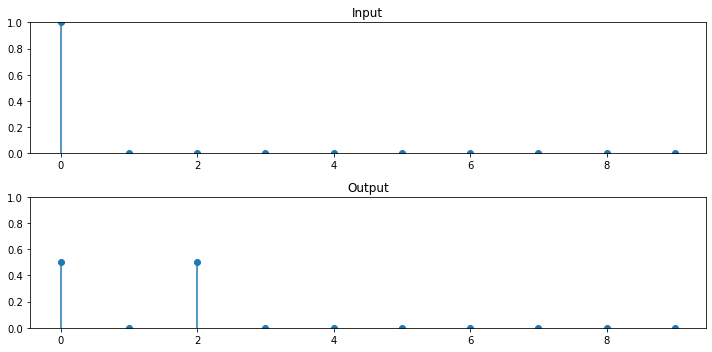

In [7]:
from matplotlib import pyplot as plt

X = jnp.concatenate([jnp.array([1]), jnp.zeros(9)])
Y = jnp.zeros(X.size)

_, (in_plot, out_plot) = plt.subplots(2, figsize=(10, 5))
in_plot.set_title('Input')
in_plot.stem(X, basefmt=' ')
in_plot.set_ylim([0, 1])
out_plot.set_title('Output')
out_plot.stem(lp_filter(X, Y, 0.5, 0.5), basefmt=' ')
out_plot.set_ylim([0, 1])
plt.tight_layout()

In [8]:
X = jnp.concatenate([jnp.array([1]), jnp.zeros(9)])
Y = jnp.zeros(X.size)
target_params = (0.5, 0.7)
target = lp_filter(X, Y, *target_params)

In [9]:
def train(params, objective, X, target, learning_rate=0.35, epochs=100):
    params_history = np.ndarray((epochs, params.size))
    Y = jnp.zeros(X.size)

    for epoch in range(epochs):
        gradient = grad(objective)(params, X, Y, target)
        params_history[epoch, :] = params
        params += learning_rate * gradient

    return params, params_history

In [10]:
%%time

epochs = 100
params = jnp.array([0.1, 0.9]) # arbitrary starting values (todo seeded random)
params, params_history = train(params, objective, X, target)

CPU times: user 9.06 s, sys: 1.22 s, total: 10.3 s
Wall time: 8.46 s


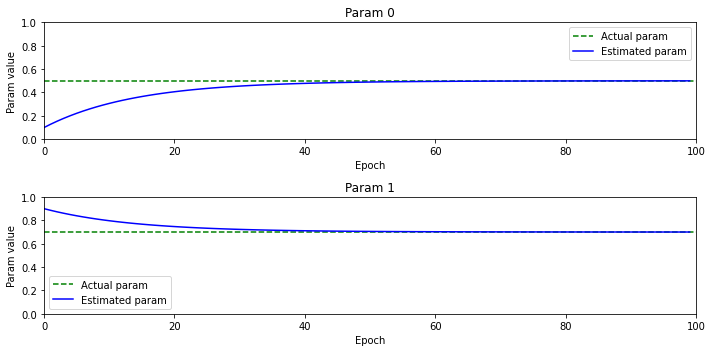

In [11]:
_, axes = plt.subplots(params.size, figsize=(10, 5))

for param_index in range(params.size):
    param_plot = axes[param_index]
    param_plot.set_title('Param %s' % param_index)
    param_plot.set_xlim([0, epochs])
    param_plot.set_ylim([0, 1])
    param_plot.set_xlabel('Epoch')
    param_plot.set_ylabel('Param value')
    param_plot.axhline(y=target_params[param_index], c='g', linestyle='--', label='Actual param')
    param_plot.plot(params_history[:,param_index], c='b', label='Estimated param')
    param_plot.legend()

plt.tight_layout()

In [12]:
# def filter_fir(coefficients, num_taps, x, filtered_signal):
#     y, Reg[256];  // This assumes <= 256 taps.

#     for(j=0; j<NumTaps; j++)Reg[j] = 0.0; // Init the delay registers.

#     for(j=0; j<NumSigPts; j++):
#         // Shift the register values down and set Reg[0].
#         for(k=NumTaps; k>1; k--)Reg[k-1] = Reg[k-2];
#         Reg[0] = Signal[j];

#         y = 0.0;
#         for(k=0; k<num_taps; k++)y += coefficients[k] * Reg[k];
#         FilteredSignal[j] = y;

In [13]:
class OneZeroFilter:
    def __init__(self, zero=-1.0):
        self.in1 = self.in2 = self.out1 = 0.0
        self.set_zero(zero)

    def tick(self, in_sample):
        self.in1 = in_sample
        self.out1 = self.b1 * self.in2 + self.b0 * self.in1
        self.in2 = self.in1

        return self.out1

    def set_zero(self, zero):
        # Normalize coefficients for unity gain
        self.b0 = 1.0 / (1.0 + zero) if zero > 0 else 1.0 / (1.0 - zero)
        self.b1 = -zero * self.b0

    # TODO could be broken
    def phase_delay(self, frequency, fs=44100):
        omega_t = 2 * np.pi * frequency / fs
        real = 0.0
        imag = 0.0
        real += self.b0 * np.cos(0)
        imag -= self.b0 * np.sin(0)
        real += self.b1 * np.cos(omega_t)
        imag += self.b1 * np.sin(omega_t)
        phase = np.arctan2(imag, real)
        phase = -phase % (2 * np.pi)
        return phase / omega_t

    def set_coefficients(self, b0, b1):
        self.b0 = b0
        self.b1 = b1

    def clear(self):
        self.in1 = self.in2 = self.out1 = 0.0

In [15]:
# import IPython
# from scipy.io.wavfile import read as wavread

# wav_fs, X = wavread('speech-male.wav')
# X = X.astype(float) / X.max()
# print('Original sample:')
# IPython.display.Audio(X, rate=wav_fs)